In [1]:
import pickle

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution

from scipy.stats import gaussian_kde


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

torch.set_default_device(device)

## Inverse problem 

In [2]:
# Parameters
T = 0.05
n_y = 100
domain = [-1, 1]
sigma_noise = 0.01**2
mu_u = -1
sigma_2_u = 0.01**2

n_x = n_y
t = np.linspace(domain[0],domain[1], n_y)
t = np.round(t, 3)
d_k = 40

h = domain[1] / n_y

params = [0, 0.8, 0., 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= -0.6:
            output[idx] = params[0]
        elif point <= 0.0:
            output[idx] = params[1]+ 0.2*np.sin(1.7*np.pi*point*2)
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.6:
            #output[idx] = params[3]
            output[idx] = params[3] #+ 0.3*np.sin(2*np.pi*point*2)
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [3]:
model = deconvolution(int(np.round(n_x/2)), int(n_x/16), 'reflect')
A = model.linear_operator(n_x)
#A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

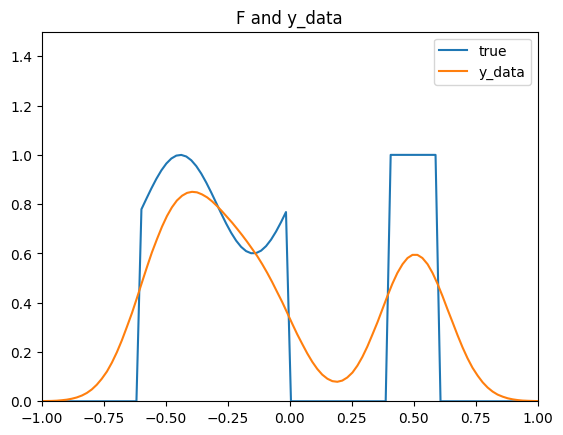

In [4]:
# Generate grid points
x = np.linspace(domain[0], domain[1] - h, n_x)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 1.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [5]:
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.01)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.01)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(0.01)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Cauchy(0.,
                                               torch.tensor(0.01)).expand([h2]).to_event(1))
        
        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.01)).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.01)).expand([h2]).to_event(1))
           
        self.fc4 = PyroModule[nn.Linear](h1, h2)
        self.fc4.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(0.01)).expand([h2, h2]).to_event(2))
        self.fc4.bias = PyroSample(dist.Cauchy(0.,
                                               torch.tensor(0.01)).expand([h2]).to_event(1))
           
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, A, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.tanh(self.fc1(x))
        mu = self.relu(self.fc2(mu))
        mu = self.relu(self.fc3(mu))
        mu = self.relu(self.fc4(mu))
        
        y_hat = torch.matmul(A, mu)
        
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(0.01)))
        with pyro.plate("data", n_y):
            obs = pyro.sample("obs", dist.Normal(y_hat, sigma), obs=y)
        
        return mu
    

In [6]:
# Convert data to PyTorch tensors
t_gpu = torch.from_numpy(t).float().cuda()
y_gpu = torch.from_numpy(y_data).float().cuda()
A_gpu = torch.from_numpy(A).float().cuda()


## Training the prior

In [7]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal
from tqdm.auto import trange
from pyro.optim import Adam


bnn_model = BNN(h1=n_y, h2=n_x)

# Set Pyro random seed
pyro.set_rng_seed(42)
'''
nuts_kernel = pyro.infer.NUTS(bnn_model, jit_compile=True)

# Define MCMC sampler, get 50 posterior samples
bnn_mcmc = pyro.infer.MCMC(nuts_kernel,
                        num_samples=10,
                        warmup_steps=200)

bnn_mcmc.run(t_gpu, A_gpu, y_gpu)
'''
guide = AutoDiagonalNormal(bnn_model)
adam_params = {"lr": 0.001, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(bnn_model, guide, optimizer, loss=Trace_ELBO())

num_iterations = 6000
progress_bar = trange(num_iterations)

for j in progress_bar:
    loss = svi.step(t_gpu, A_gpu, y_gpu)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(t_gpu)))



  0%|          | 0/6000 [00:00<?, ?it/s]

In [8]:
#predictive = pyro.infer.Predictive(model=bnn_model, posterior_samples=bnn_mcmc.get_samples(), return_sites=["_RETURN"])

predictive = pyro.infer.Predictive(bnn_model, guide=guide, num_samples=2000, return_sites=["_RETURN"])

preds_gpu = predictive(t_gpu, A_gpu)

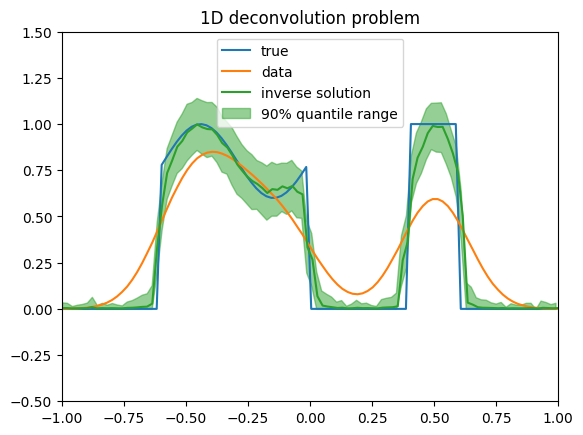

In [9]:
x_preds_cpu = preds_gpu['_RETURN'].cpu()

x_solution = torch.mean(x_preds_cpu, axis=0)
lower_quantile = torch.quantile(x_preds_cpu, 0.05, axis=0)
upper_quantile = torch.quantile(x_preds_cpu, 0.95, axis=0)



plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='data')

line, = plt.plot(t, x_solution, label='inverse solution')
# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color=line.get_color(), alpha=0.5, label='90% quantile range')
#plt.plot(t, A@x_solution.numpy(), label='A @ solution')

plt.axis([domain[0], domain[1], -0.5, 1.5])
plt.title('1D deconvolution problem')
plt.legend()
plt.show()